# Kaggle on Forest Cover Type prediction 

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
import seaborn as sns
import pandas as pd
import numpy as np
df_test = pd.read_csv("/Users/guillaumequispe/PycharmProjects/Guillaume_QUISPE/INF701/test-set.csv")
df_train = pd.read_csv("/Users/guillaumequispe/PycharmProjects/Guillaume_QUISPE/INF701/train-set.csv")


Fonction used later to get the result of cross validation 

In [81]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [82]:
df_X_train=df_train.drop(['Cover_Type'], axis=1)
df_y_train=df_train["Cover_Type"]

In [83]:
df_X_train.set_index("Id")
df_test.set_index("Id")
df_X_train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,1,2611,326,20,120,27,1597,168,214,184,...,0,0,0,0,0,0,0,0,0,0
1,2,2772,324,17,42,7,1814,175,220,183,...,0,0,0,0,0,0,0,0,0,0
2,3,2764,4,14,480,-21,700,201,212,148,...,0,0,0,0,0,0,0,0,0,0
3,4,3032,342,9,60,8,4050,202,227,164,...,0,0,0,0,0,0,0,0,0,0
4,5,2488,23,11,117,21,1117,209,218,151,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#scatter_matrix(df_train[:56], figsize=(6, 6), diagonal='kde')

Creating new feature, taking the norm2 of the x y distances

In [57]:
df_X_train["Distance_To_Hydrology"]=np.sqrt(df_X_train['Horizontal_Distance_To_Hydrology']**2+df_X_train['Vertical_Distance_To_Hydrology']**2)
#df_X_train=df_X_train.drop(['Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology'], axis=1)

In [58]:
df_test["Distance_To_Hydrology"]=np.sqrt(df_test['Horizontal_Distance_To_Hydrology']**2+df_test['Vertical_Distance_To_Hydrology']**2)
#df_test=df_test.drop(['Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology'], axis=1)

In [59]:
#df_X_train[['Hillshade_9am','Hillshade_Noon']] = np.square(df_X_train[['Hillshade_9am','Hillshade_Noon']])
#df_test[['Hillshade_9am','Hillshade_Noon']] = np.square(df_test[['Hillshade_9am','Hillshade_Noon']])

In [60]:
print(df_test.shape)
print(df_X_train.shape)

(226595, 56)
(528720, 56)


In [61]:
df_test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Distance_To_Hydrology
0,528721,2953,224,9,55,11,1600,206,251,176,...,1,0,0,0,0,0,0,0,0,56.089215
1,528722,2977,233,14,42,1,1282,196,252,192,...,0,0,0,0,0,0,0,0,0,42.011903
2,528723,3055,227,9,120,5,2724,207,249,178,...,0,0,0,0,0,0,0,0,0,120.104121
3,528724,2615,107,13,277,74,967,241,224,110,...,0,0,0,0,0,0,0,0,0,286.714143
4,528725,3033,59,15,457,94,4086,233,213,99,...,0,0,0,0,0,0,0,0,0,466.567251


Creating new features by combining the most relevant ones. 
This aspect is largely inspired by the https://www.kaggle.com/codename007/forest-cover-type-eda-baseline-model
I check after adding these features that the f1 score increases.


In [62]:
df_X_train['Mean_Amenities']=(df_X_train.Horizontal_Distance_To_Fire_Points + df_X_train.Horizontal_Distance_To_Hydrology + df_X_train.Horizontal_Distance_To_Roadways) / 3 
df_X_train['Mean_Fire_Hyd']=(df_X_train.Horizontal_Distance_To_Fire_Points + df_X_train.Horizontal_Distance_To_Hydrology) / 2

df_test['Mean_Amenities']=(df_test.Horizontal_Distance_To_Fire_Points + df_test.Horizontal_Distance_To_Hydrology + df_test.Horizontal_Distance_To_Roadways) / 3 
df_test['Mean_Fire_Hyd']=(df_test.Horizontal_Distance_To_Fire_Points + df_test.Horizontal_Distance_To_Hydrology) / 2

In [63]:
df_X_train['HF1'] = df_X_train['Horizontal_Distance_To_Hydrology']+df_X_train['Horizontal_Distance_To_Fire_Points']
df_X_train['HF2'] = abs(df_X_train['Horizontal_Distance_To_Hydrology']-df_X_train['Horizontal_Distance_To_Fire_Points'])
df_X_train['HR1'] = abs(df_X_train['Horizontal_Distance_To_Hydrology']+df_X_train['Horizontal_Distance_To_Roadways'])
df_X_train['HR2'] = abs(df_X_train['Horizontal_Distance_To_Hydrology']-df_X_train['Horizontal_Distance_To_Roadways'])
df_X_train['FR1'] = abs(df_X_train['Horizontal_Distance_To_Fire_Points']+df_X_train['Horizontal_Distance_To_Roadways'])
df_X_train['FR2'] = abs(df_X_train['Horizontal_Distance_To_Fire_Points']-df_X_train['Horizontal_Distance_To_Roadways'])
df_X_train['ele_vert'] = df_X_train.Elevation-df_X_train.Vertical_Distance_To_Hydrology

In [64]:
df_test['HF1'] = df_test['Horizontal_Distance_To_Hydrology']+df_test['Horizontal_Distance_To_Fire_Points']
df_test['HF2'] = abs(df_test['Horizontal_Distance_To_Hydrology']-df_test['Horizontal_Distance_To_Fire_Points'])
df_test['HR1'] = abs(df_test['Horizontal_Distance_To_Hydrology']+df_test['Horizontal_Distance_To_Roadways'])
df_test['HR2'] = abs(df_test['Horizontal_Distance_To_Hydrology']-df_test['Horizontal_Distance_To_Hydrology'])
df_test['FR1'] = abs(df_test['Horizontal_Distance_To_Fire_Points']+df_test['Horizontal_Distance_To_Roadways'])
df_test['FR2'] = abs(df_test['Horizontal_Distance_To_Fire_Points']-df_test['Horizontal_Distance_To_Roadways'])
df_test['ele_vert'] = df_test.Elevation-df_test.Vertical_Distance_To_Hydrology

In [65]:
df_X_train=df_X_train.set_index("Id")
df_test=df_test.set_index("Id")


In [66]:
df_X_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Distance_To_Hydrology,Mean_Amenities,Mean_Fire_Hyd,HF1,HF2,HR1,HR2,FR1,FR2,ele_vert
Id,,,,,,,,,,,,,,,,,,,,,
1,2611,326,20,120,27,1597,168,214,184,2913,...,123.000000,1543.333333,1516.5,3033,2793,1717,1477,4510,1316,2584
2,2772,324,17,42,7,1814,175,220,183,2879,...,42.579338,1578.333333,1460.5,2921,2837,1856,1772,4693,1065,2765
3,2764,4,14,480,-21,700,201,212,148,700,...,480.459155,626.666667,590.0,1180,220,1180,220,1400,0,2785
4,3032,342,9,60,8,4050,202,227,164,2376,...,60.530984,2162.000000,1218.0,2436,2316,4110,3990,6426,1674,3024
5,2488,23,11,117,21,1117,209,218,151,1136,...,118.869677,790.000000,626.5,1253,1019,1234,1000,2253,19,2467


In [67]:
df_test.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Distance_To_Hydrology,Mean_Amenities,Mean_Fire_Hyd,HF1,HF2,HR1,HR2,FR1,FR2,ele_vert
Id,,,,,,,,,,,,,,,,,,,,,
528721,2953,224,9,55,11,1600,206,251,176,1669,...,56.089215,1108.000000,862.0,1724,1614,1655,0,3269,69,2942
528722,2977,233,14,42,1,1282,196,252,192,277,...,42.011903,533.666667,159.5,319,235,1324,0,1559,1005,2976
528723,3055,227,9,120,5,2724,207,249,178,908,...,120.104121,1250.666667,514.0,1028,788,2844,0,3632,1816,3050
528724,2615,107,13,277,74,967,241,224,110,3545,...,286.714143,1596.333333,1911.0,3822,3268,1244,0,4512,2578,2541
528725,3033,59,15,457,94,4086,233,213,99,4974,...,466.567251,3172.333333,2715.5,5431,4517,4543,0,9060,888,2939


Here I tried to standardize the non categorical values but this action decreases a little the score so I commented it 

In [68]:
#Ici la std n'améliore pas le score
#df_X_train[df_X_train.columns[0:10]].head()

#scaler = StandardScaler()
#xsc=scaler.fit_transform(df_X_train[df_X_train.columns[0:10]])
#xsc2=scaler.fit_transform(df_X_train[df_X_train.columns[55:57]])


#df_X_train[df_X_train.columns[0:10]]=xsc
#df_X_train[df_X_train.columns[55:57]]=xsc2

Here I try to select the best features with SelectKBest function 

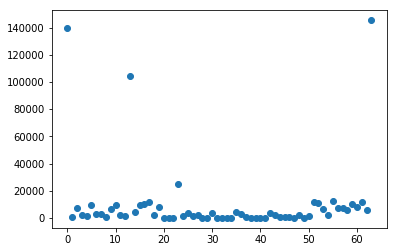

In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


kbest = SelectKBest(f_classif, k=50)
select_feature=kbest.fit(df_X_train, df_y_train)
#print(select_feature.scores_)
df_X_train_selected=select_feature.transform(df_X_train)
df_test_selected=select_feature.transform(df_test)
plt.scatter(np.arange(len(select_feature.scores_)), select_feature.scores_)
plt.show()

In [76]:
bestfeatures= pd.DataFrame(select_feature.scores_)
bestfeatures= bestfeatures.sort_values(by=0, ascending=0)
dd=df_X_train.columns[bestfeatures.index]
dd

Index(['ele_vert', 'Elevation', 'Wilderness_Area4', 'Soil_Type10',
       'Mean_Amenities', 'FR1', 'Soil_Type4', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type3', 'HR1', 'Wilderness_Area1', 'Soil_Type2',
       'Horizontal_Distance_To_Roadways', 'HR2', 'Soil_Type6', 'Mean_Fire_Hyd',
       'HF1', 'Slope', 'Soil_Type40', 'Horizontal_Distance_To_Fire_Points',
       'FR2', 'HF2', 'Soil_Type1', 'Soil_Type22', 'Soil_Type12', 'Soil_Type29',
       'Soil_Type17', 'Soil_Type23', 'Hillshade_9am', 'Hillshade_Noon',
       'Soil_Type5', 'Soil_Type14', 'Horizontal_Distance_To_Hydrology',
       'Wilderness_Area2', 'Soil_Type35', 'Soil_Type30',
       'Distance_To_Hydrology', 'Soil_Type13', 'Soil_Type37',
       'Wilderness_Area3', 'Vertical_Distance_To_Hydrology', 'Soil_Type11',
       'Soil_Type32', 'Hillshade_3pm', 'Soil_Type33', 'Soil_Type24',
       'Soil_Type31', 'Aspect', 'Soil_Type18', 'Soil_Type26', 'Soil_Type21',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type34', 'Soil_Type16',
       

Here I split my train set into train and validation set to get an idea of what effect does a little change on parameter have on the score.
But this is not the final model

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_X_train_selected, df_y_train.values.ravel(), test_size=0.2, shuffle=False)

In [50]:
forest = ExtraTreesClassifier(n_estimators=20, criterion="entropy")
forest.fit(X_train, y_train)
ypred=forest.predict(X_test)
f1scorem=f1_score(y_test, ypred, average="macro")
f1scorew=f1_score(y_test, ypred, average="weighted")
print(f1scorem)
print(f1scorew)

0.9224907149370204
0.9534416636042725


Here I do a sort of CV with randomizedSearchCV to get best parameters of the classifier 

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

forest3 = ExtraTreesClassifier(n_estimators=10)
param_dist = {"max_depth": [20, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

n_iter_search = 5
random_search = RandomizedSearchCV(forest3, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

#random_search.fit(X, y)

random_search.fit(X_train, y_train)
report(random_search.cv_results_)


ypred3=random_search.predict(X_test)
f1scorem=f1_score(y_test, ypred3, average="macro")
f1scorew=f1_score(y_test, ypred3, average="weighted")
print(f1scorem)
print(f1scorew)

Model with rank: 1
Mean validation score: 0.941 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.930 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.925 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 4}

0.9060149349772708
0.9443605052396981


Finally I train my model with the entire train set. The score is expected to be 1 because we predict values for data we trained on

In [26]:
forest2 = ExtraTreesClassifier(n_estimators=450, n_jobs=-1,criterion="entropy")
forest2.fit(df_X_train_selected, df_y_train)
ypred2=forest2.predict(X_test)
f1scorem=f1_score(y_test, ypred2, average="macro")
f1scorew=f1_score(y_test, ypred2, average="weighted")
print(f1scorem)
print(f1scorew)



1.0
1.0


Finally I save the prediction to a csv file

In [27]:
ypredtest=forest2.predict(df_test_selected)


cc=pd.DataFrame(df_test.index)
cc["Cover_Type"]=ypredtest
cc.head()
cc=cc.set_index("Id")
cc.head()
prediction = pd.DataFrame(cc).to_csv('prediction.csv')



In [ ]:
'''
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(
                              random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'max_depth': [20,30],
                    'n_estimators':[100,200]}]
clf = GridSearchCV(forest, tuned_parameters, cv=5,
                       scoring="f1_weighted")
clf.fit(X_train, y_train.values.ravel())

forest.fit(X_train, y_train.values.ravel())
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("ok")
'''

In [ ]:
print(clf.best_params_)
print(clf.cv_results_)

In [ ]:
clf.score(X_test, y_test.values.ravel())

In [ ]:
ypred=forest.predict(X_test)
f1scorem=f1_score(y_test.values.ravel(), ypred, average="macro")
f1scorew=f1_score(y_test.values.ravel(), ypred, average="weighted")
print(f1scorem)
print(f1scorew)


In [ ]:
score= forest.score(X_test,y_test.values.ravel())

print( score)
f1_score=f1_score(y_test, ypred)

In [ ]:

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
x[x.columns[0:9]].head()
cols=np.append(x.columns[0:9],["Mean_Amenities","Mean_Fire_Hyd"])
print(cols)

xstd=x
scaler = StandardScaler()
xsc=scaler.fit_transform(xstd[cols])

#print(df_X_train.columns[10:54])
xstd=np.concatenate((xsc,df_X_train[df_X_train.columns[10:54]]),axis=1 )
#xstd[xstd.columns[0:9]]=xsc
pd.DataFrame(xstd).describe()
x.describe()
plt.matshow(df_train.corr())

In [ ]:
df1 = df_train[:100]
print(df1.shape)
u,s,v = np.linalg.svd(df1)
plt.plot(s)
plt.show()
pd.DataFrame(s<10**-7)[0].value_counts()

In [ ]:
pcax = PCA(n_components=41)
xpc=pcax.fit(xstd)
xpca=xpc.transform(xstd)



In [ ]:
plt.matshow(pd.DataFrame(xpca).corr())